Compare the ACF (and MSD) from bulk water trajectories under two different force fields.

Continuing from `p20201204b_ACF_comparison.ipynb`.

## Setup

In [1]:
import os
import os.path as osp

In [2]:
import sys

In [3]:
sys.path.append('../modules')

In [4]:
import xvg_conversion as xvg

In [5]:
import numpy as np

In [6]:
import pandas as pd

In [7]:
import matplotlib.pyplot as plt

In [8]:
%matplotlib inline

In [9]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [10]:
from datetime import datetime

In [11]:
from ruamel.yaml import YAML

In [12]:
yaml=YAML(typ="safe",pure=True)

In [13]:
import scipy.constants

In [14]:
physical_constants=scipy.constants.physical_constants

In [15]:
def readfile(fpath,multidoc=False):
  with open(fpath,"r") as fp:
    dat=fp.read()
  if multidoc:
    allobj=yaml.load_all(dat)
  else:
    allobj=yaml.load(dat)
  return allobj

## Output plot paths

In [16]:
outdir_top="../postproc/from_notebooks"
assert osp.isdir(outdir_top)

In [17]:
datestr=datetime.now().strftime("%Y_%m_%d")
datestr

'2021_01_12'

In [18]:
outdir=osp.join(outdir_top,datestr)

In [19]:
if not osp.isdir(outdir):
  os.makedirs(outdir)

In [20]:
assert osp.isdir(outdir)

## Constants

In [21]:
basic_columns=['t','x','y','z']
corrheadings=[['t','x'], ['t','y'], ['t','z']]
acf_structure=[2,2,2]
traj_structure=[4]

In [22]:
Temperature = 298 #K

In [23]:
springK_permole = 300 * 1000 # J/nm^2/mol

## Computed expected MSD

In [24]:
kB_all=physical_constants['Boltzmann constant']
kB=kB_all[0] #J/K
assert kB_all[1]=='J K^-1'

In [25]:
nA_all=physical_constants['Avogadro constant']
nA=nA_all[0]
assert nA_all[1]=='mol^-1'

In [26]:
springK = springK_permole / nA # J/nm^2
springK

4.98161720152154e-19

In [27]:
kBT = kB * Temperature # J
kBT

4.11433402e-21

In [28]:
expected_MSD = kBT / springK # nm^2
expected_MSD

0.008259032867365552

## Experimental $D$ result

from Witherspoon and Saraf, 1965.

In [29]:
D_data_cel={24.8: 1.88, 35.1: 2.12, 42.6: 2.41} #[Celsius]: [1e-5 cm^2/sec]

In [30]:
zeroK = scipy.constants.zero_Celsius
zeroK

273.15

In [31]:
D_data=dict((T+zeroK,v) for T,v in D_data_cel.items()) #[Kelvin]: [1e-5 cm^2/sec]
D_data

{297.95: 1.88, 308.25: 2.12, 315.75: 2.41}

In [32]:
experimental_D=D_data[297.95]
experimental_D #1e-5 cm^2/sec

1.88

## Load all data

Directories

In [33]:
topdata="../jobs/run/bulk02"

In [34]:
assert osp.isdir(topdata)

In [35]:
tags=["Selected Force Field","GROMOS 53A6"]

In [36]:
subdirs=['oldff-long','test05']

In [37]:
data_folders=[osp.join(topdata,sd) for sd in subdirs]

In [38]:
assert all([osp.isdir(df) for df in data_folders])

$D_{local}$ Calculation results

In [39]:
calc_results_fname="810_results_D_local.yaml"

In [40]:
results_dicts=[]
for idx,subdir in enumerate(data_folders):
  rdfpath=osp.join(subdir,calc_results_fname)
  assert osp.isfile(rdfpath)
  fdata=readfile(rdfpath)
  results_dicts.append(fdata)

ACF

In [41]:
acf_fname="720_acf.xvg"

In [42]:
acf_data=[]
for idx,subdir in enumerate(data_folders):
  acfpath=osp.join(subdir,acf_fname)
  assert osp.isfile(acfpath)
  corrsets=xvg.read_all_sets(acfpath)
  corrframes=xvg.sets_to_frames(corrsets,corrheadings)
  corrdf=xvg.combine_frames(corrframes,['t'])
  acf_data.append(corrdf)

Trajectories

In [43]:
# traj_fname="710_traj.xvg"

In [44]:
# traj_data=[]
# for idx,subdir in enumerate(data_folders):
#   trajfpath=osp.join(subdir,traj_fname)
#   assert osp.isfile(trajfpath)
#   trajsets=xvg.read_all_sets(trajfpath)
#   trajframes=xvg.sets_to_frames(trajsets,[basic_columns])
#   intraj=trajframes[0]
#   traj_data.append(intraj)

## Compare MSDs

In [45]:
expected_MSD

0.008259032867365552

In [46]:
columns=['Direction','Expected']+tags
dfdata=[]
for coord in "xyz":
  row=[coord,expected_MSD]
  for idx,tag in enumerate(tags):
    row.append(results_dicts[idx]["msd_values"][coord])
  dfdata.append(row)
msd_df=pd.DataFrame(dfdata,columns=columns)
msd_df=msd_df.set_index('Direction')
msd_df

,Expected,Selected Force Field,GROMOS 53A6
Direction,,,
x,0.008259,0.008112,0.008107
y,0.008259,0.007907,0.008112
z,0.008259,0.008288,0.007911


The MSD values returned by the MD simulations are slightly lower than the theoretical MSD value of $k_B T / K$,
but the results from the two force fields seem to be consistent with each other.

## Compare $D$ results

In [47]:
experimental_D

1.88

In [48]:
conversion_factor=1e3 #From nm^2/psec to 1e-5 cm^2/sec

In [49]:
columns=['Direction','Experimental']+tags
dfdata=[]
for coord in "xyz":
  row=[coord,experimental_D]
  for idx,tag in enumerate(tags):
    assert results_dicts[idx]["match_ok"][coord]
    result=conversion_factor*results_dicts[idx]["fit_results"]["D"][coord]
    row.append(result)
  dfdata.append(row)
D_df=pd.DataFrame(dfdata,columns=columns)
D_df=D_df.set_index('Direction')
D_df

,Experimental,Selected Force Field,GROMOS 53A6
Direction,,,
x,1.88,3.134754,1.910608
y,1.88,2.958903,1.727854
z,1.88,3.061781,1.852438


In [50]:
D_res_outfile=osp.join(outdir,"FF_comparison_Dvalues.csv")
D_df.to_csv(D_res_outfile)

## Plot ACFs

In [51]:
coord="z"
tmax=25.0
#tmax=50.0

In [52]:
formats=['r-','k--']

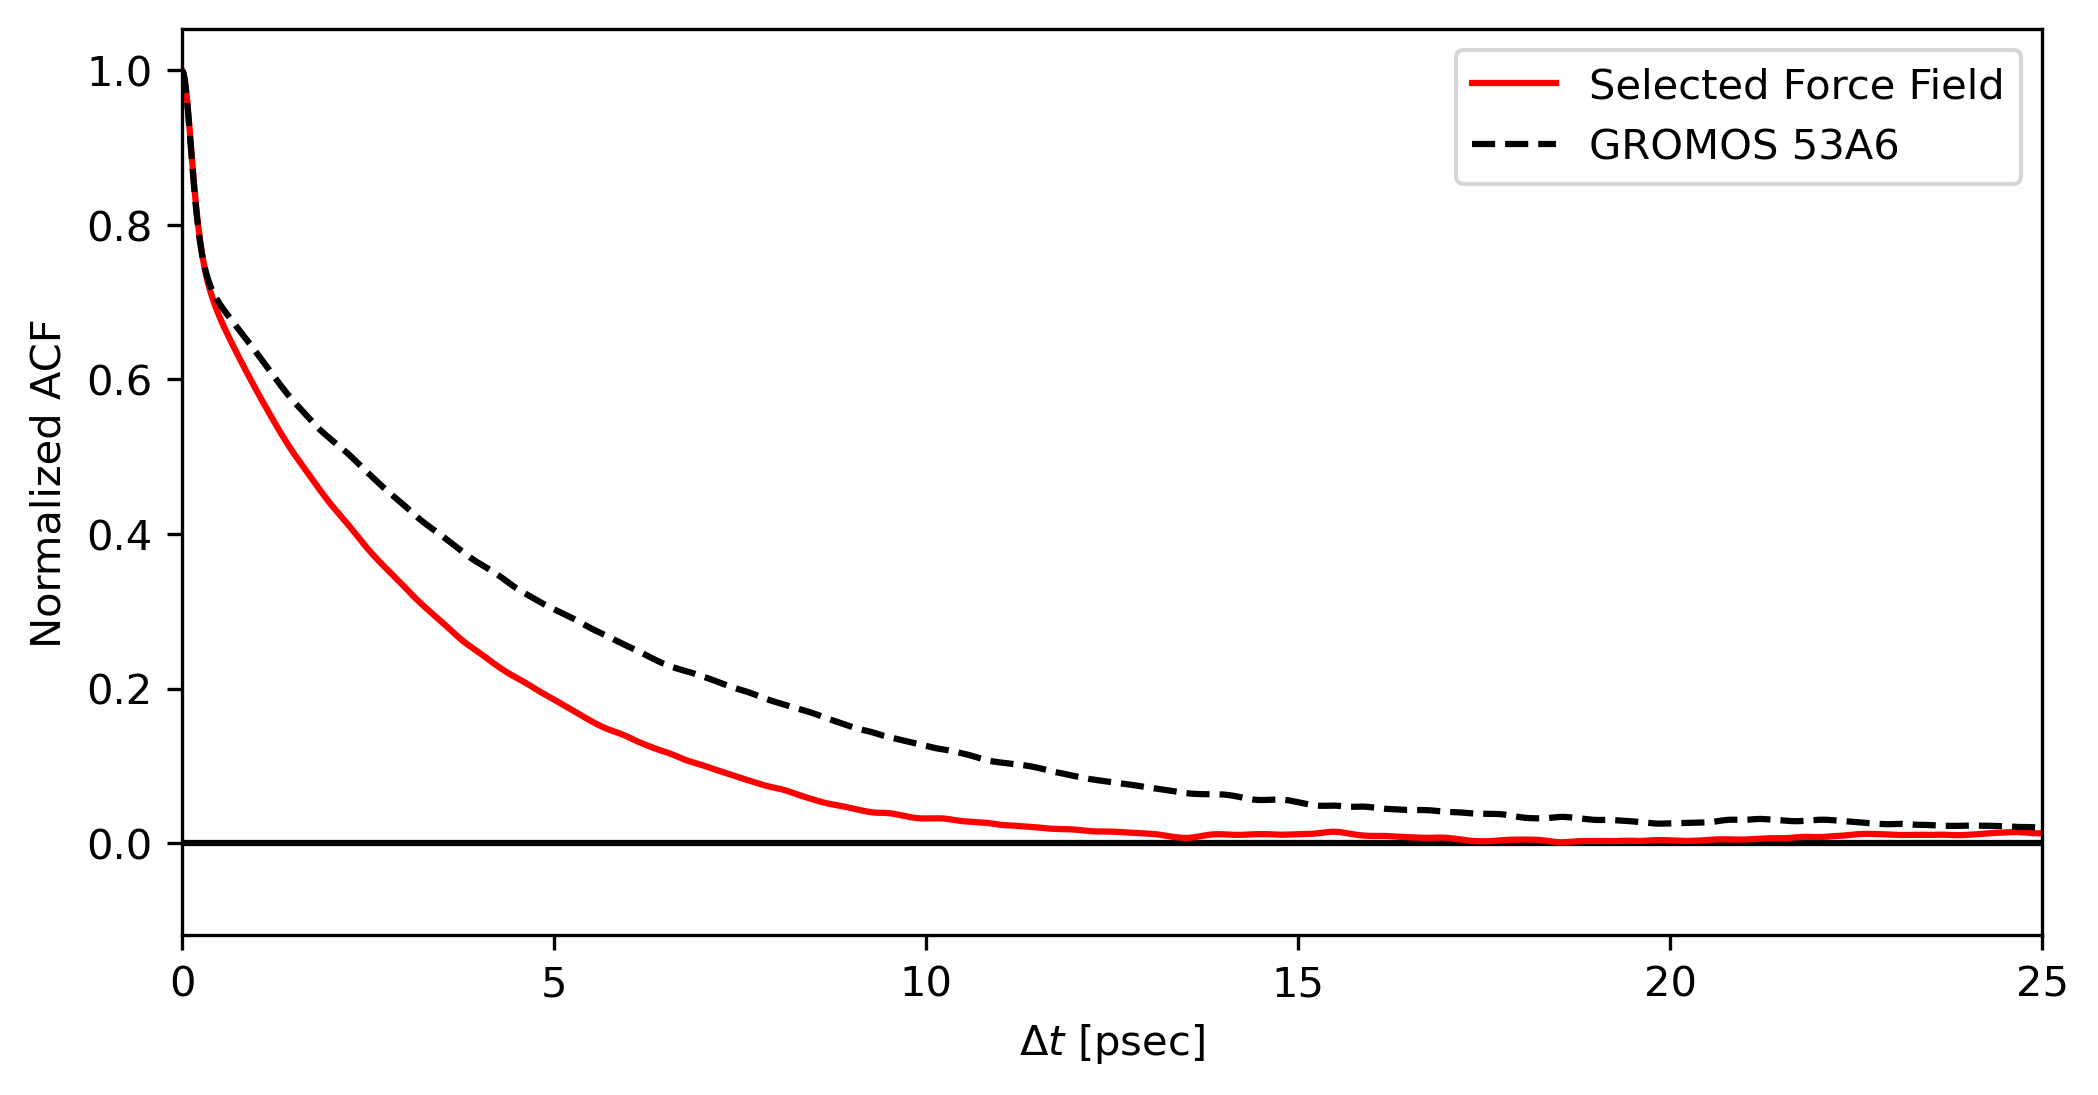

In [53]:
fig,ax=plt.subplots(1,1,figsize=(8,4))
for idx,tag in enumerate(tags):
  acf=acf_data[idx]
  o=ax.plot(acf['t'],acf[coord],formats[idx],label=tag)
o=ax.set_xlim(0,tmax)
o=ax.hlines(0,0,tmax,'k')
o=ax.legend(loc="upper right")
#o=ax.set_title("")
o=ax.set_ylabel("Normalized ACF")
o=ax.set_xlabel("$\Delta t$ [psec]")
#Save figure
plot_path=osp.join(outdir,"FF_comparison.png")
# fig.tight_layout()
fig.savefig(str(plot_path))

Normalized position autocorrelation functions for methane in bulk water, using two different force fields, in a single direction.
The results from the GROMOS 53A6 provide a diffusion coefficient that matches physical measurement.